开始读取并解析文件: foods.txt...
文件解析完成。共录入 568454 条评论。
初始数据量: 568454

正在筛选 Top 100 用户和 Top 100 美食...
筛选后数据量: 704 条评论
最终矩阵维度: 70 (Users) x 88 (Products)


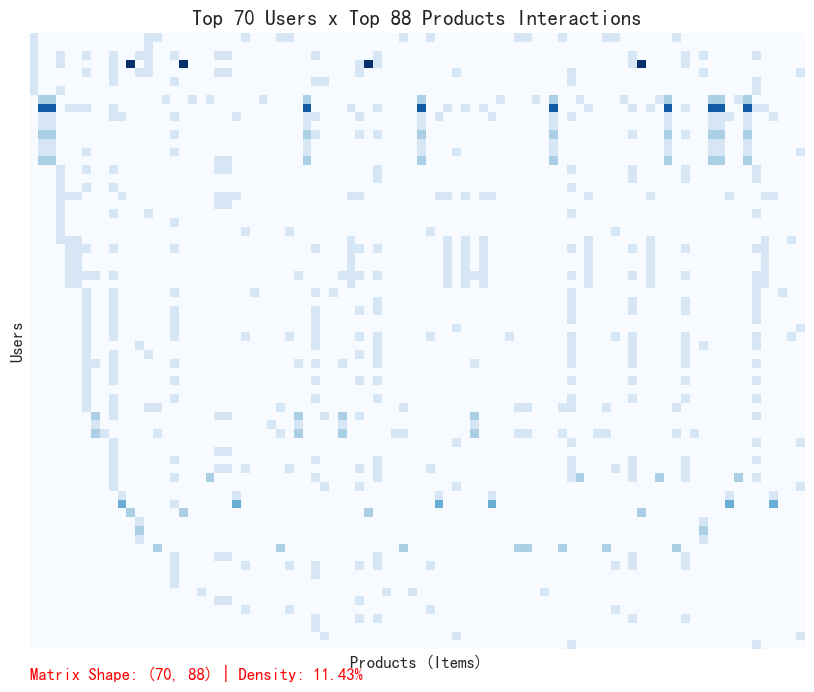


构建词汇表...
最终词汇表大小 V: 554
构建文本矩阵 W...
数据准备完毕。包含 704 条有效文本评论。

现在可以将 ltbm_data['A'] 和 ltbm_data['W'] 传入 LTBM 模型进行训练了。


In [16]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re # <-- Ajouté: pour un nettoyage de texte plus robuste

# --- Configuration des paramètres clés ---
FILE_PATH = 'foods.txt'  # Veuillez vous assurer que ce fichier est dans le même répertoire
TARGET_M_USERS = 100     # Nombre cible d'utilisateurs (M)
TARGET_P_PRODUCTS = 100  # Nombre cible de produits (P)
MIN_VOCAB_FREQUENCY = 20 # Fréquence minimale d'apparition d'un mot (pour construire le vocabulaire)

# --- Définition de la liste des mots vides (Stop Words) ---
STOP_WORDS = set([
    'the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'and', 'or', 'but', 'if', 'because', 'as', 'of', 'at', 'by', 'for',
    'with', 'about', 'against', 'between', 'into', 'through', 'during',
    'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some',
    'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should',
    'now', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
    'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him',
    'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its',
    'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'this', 'that', 'these', 'those', 'what', 'which', 'who', 'whom',
    'this', 'that', 'have', 'has', 'had', 'do', 'does', 'did', 'doing',

    # Mots vides de base et balises web précédemment ajoutés
    'she', 'he', 'it', 'they', 'i', 'you', 'we', # Sujets
    'so', 'oh', 'well', 'like', 'but', 'just', # Interjections/Mots de remplissage
    'href', 'http', 'com', 'www', 'img', 'src', # Lié au web
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', # Mots d'une seule lettre
    '2)', '</a>', # Anciens fragments
    'already', 'happy', 'anything', 'theyre', 'lot', 'good', 'impressed', 'far', 'came', 'another', 'side', 'count', 'case', 'me',

    # NOUVEAUX AJOUTS (Tour 2) - Suppression des mots génériques
    'aroma', 'timothy', 'whole', 'long', 'mini', 'thing', 'top', 'fine',
    'found', 'mean', 'mine', 'said', 'noticed', 'sure', 'plan', 'pick',
    'carry', 'review', 'wasn', # Tour 2

    # NOUVEAUX AJOUTS (Tour 3) - Suppression des mots génériques
    'getting', 'past', 'mostly', 'stronger', 'nothing', 'pleasant',
    'five', 'raw', 'see', 'pass', 'strange', 'house', 'market',
    'finish', 'love', 'care', 'later', 'day', 'flavor', 'awesome',
    'flavorful', # Tour 3

    # <-- NOUVEAUX AJOUTS (Tour 4) basés sur la dernière analyse des sujets (T1-T4) -->
    'consider', 'afternoon', 'soon', 'listed', 'gave', 'please',
    'expensive', 'would', 'seemed', 'note', 'decided', 'could',
    'stick', 'rest', 'work', 'morning', 'sales', 'looks', 'package' # Inclut package
])

# --- 1. Analyse des données (Lecture à partir du fichier réel uniquement) ---
def parse_review_data(file_path: str) -> List[Dict]:
    """
    Analyse le fichier de données de commentaires Amazon en blocs.
    S'exécute uniquement si le fichier existe, sinon lève une exception.

    @param file_path: Chemin du fichier de données
    @return: Liste des dictionnaires de commentaires
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Erreur: Fichier introuvable '{file_path}'. Veuillez vous assurer que le chemin est correct.")

    print(f"Début de la lecture et de l'analyse du fichier: {file_path}...")
    data = []

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        current_review = {}
        for line in f:
            line = line.strip()
            if line:
                # Analyse de la structure clé: valeur
                if ':' in line:
                    try:
                        parts = line.split(':', 1)
                        key = parts[0].strip()
                        value = parts[1].strip()

                        # Traiter les préfixes comme review/userId, ne garder que userId
                        if '/' in key:
                            key = key.split('/')[-1]

                        current_review[key] = value
                    except ValueError:
                        continue
            else:
                # Ligne vide sépare les commentaires, sauvegarde l'enregistrement complet précédent
                if current_review:
                    # S'assurer que les champs nécessaires existent
                    if 'productId' in current_review and 'userId' in current_review and 'text' in current_review:
                        data.append(current_review)
                current_review = {}

        # Traiter le dernier commentaire possible à la fin du fichier
        if current_review and 'productId' in current_review and 'userId' in current_review and 'text' in current_review:
            data.append(current_review)

    print(f"Analyse du fichier terminée. {len(data)} commentaires enregistrés.")
    return data

# --- 2. Filtrage itératif (Prétraitement) ---
def filter_by_min_activity(df_in: pd.DataFrame, min_user: int, min_product: int) -> pd.DataFrame:
    """Supprime itérativement les données à très faible fréquence pour assurer la qualité des données."""
    df = df_in.copy()
    print(f"Taille initiale des données: {len(df)}")
    while True:
        # 1. Filtrer les produits
        product_counts = df['productId'].value_counts()
        popular_products = product_counts[product_counts >= min_product].index
        df_new = df[df['productId'].isin(popular_products)]

        # 2. Filtrer les utilisateurs
        user_counts = df_new['userId'].value_counts()
        active_users = user_counts[user_counts >= min_user].index
        df_new = df_new[df_new['userId'].isin(active_users)].copy() # Note: Utiliser df_new['userId'] ici

        # 3. Vérifier la convergence
        if len(df_new) == len(df):
            break
        df = df_new
    return df

# --- 3. Nettoyage de texte (Corrigé : utilise la variable globale STOP_WORDS) ---
def simple_clean(text: str) -> List[str]:
    """
    Nettoyage de texte : minuscules, tokenisation, suppression des mots de moins de 3 caractères,
    suppression des mots vides et suppression de la ponctuation.

    @param text: Texte à nettoyer
    @return: Liste de mots nettoyés
    """
    global STOP_WORDS

    # Nouvelle étape 1 : Remplacer tous les caractères non alphanumériques par un seul espace
    # (y compris la ponctuation, les fragments de balises HTML, etc.)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text))

    # 1. Minuscules et tokenisation
    words = text.lower().split()

    # 2. Supprimer les mots de moins de 3 caractères
    words = [w for w in words if len(w) >= 3]

    # 3. Supprimer les mots vides (en utilisant la variable globale STOP_WORDS)
    words = [w for w in words if w not in STOP_WORDS]

    return words

# --- 4. Fonction de visualisation ---
def plot_interaction_heatmap(A_dense: np.ndarray, title="Carte thermique d'interaction Utilisateur-Produit"):
    """
    Trace la carte thermique de la matrice d'association binaire.

    @param A_dense: Matrice d'association binaire
    @param title: Titre du graphique
    """
    plt.figure(figsize=(10, 8))

    # Tracer la carte thermique (une couleur foncée indique une interaction)
    sns.heatmap(A_dense, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)

    plt.title(title, fontsize=15)
    plt.xlabel("Produits (Items)", fontsize=12)
    plt.ylabel("Utilisateurs", fontsize=12)

    # Afficher la densité de la matrice
    density = np.sum(A_dense) / A_dense.size * 100
    plt.text(0, A_dense.shape[0] + 0.05 * A_dense.shape[0],
             f"Forme de la matrice: {A_dense.shape} | Densité: {density:.2f}%",
             fontsize=12, color='red')

    plt.show()

# --- Logique du programme principal ---
def prepare_ltbm_data_real(file_path: str, target_m: int, target_p: int, min_vocab_freq: int) -> Dict[str, Any]:
    """
    Prépare les matrices A (association) et W (texte) nécessaires pour le modèle LTBM.

    @param file_path: Chemin du fichier de données
    @param target_m: Nombre cible d'utilisateurs M
    @param target_p: Nombre cible de produits P
    @param min_vocab_freq: Fréquence minimale du vocabulaire
    @return: Dictionnaire contenant A, W, vocabulary, M, P, V
    """
    # 1. Chargement des données
    try:
        data = parse_review_data(file_path)
    except FileNotFoundError as e:
        print(e)
        return {}

    df = pd.DataFrame(data)
    if df.empty:
        print("Avertissement: L'ensemble de données est vide.")
        return {}

    # Conversion des types
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df.dropna(subset=['text', 'score'], inplace=True)

    # 2. Nettoyage préliminaire (au moins 1 commentaire pour être conservé)
    df = filter_by_min_activity(df, min_user=1, min_product=1)

    # 3. Étape clé : Filtrage Top-N (méthode de l'intersection)
    print(f"\nFiltrage des Top {target_m} utilisateurs et Top {target_p} produits alimentaires...")

    # Trouver les M utilisateurs avec le plus de commentaires au total
    top_users = df['userId'].value_counts().head(target_m).index
    # Trouver les P produits avec le plus de commentaires au total
    top_products = df['productId'].value_counts().head(target_p).index

    # Ne conserver que les commentaires de ces utilisateurs Top sur ces produits Top (intersection)
    df_filtered = df[
        df['userId'].isin(top_users) &
        df['productId'].isin(top_products)
    ].copy()

    # 4. Encodage des ID
    user_to_id = {u: i for i, u in enumerate(df_filtered['userId'].unique())}
    prod_to_id = {p: i for i, p in enumerate(df_filtered['productId'].unique())}

    df_filtered['uid_idx'] = df_filtered['userId'].map(user_to_id)
    df_filtered['pid_idx'] = df_filtered['productId'].map(prod_to_id)

    M = len(user_to_id) # Nombre final d'utilisateurs
    P = len(prod_to_id) # Nombre final de produits

    print(f"Taille des données après filtrage: {len(df_filtered)} commentaires")
    print(f"Dimensions finales de la matrice: {M} (Utilisateurs) x {P} (Produits)")

    # 5. Construction de la matrice A (Matrice d'association/d'incidence)
    rows = df_filtered['uid_idx']
    cols = df_filtered['pid_idx']
    data_ones = np.ones(len(df_filtered))

    # Construire la matrice creuse puis la convertir en dense
    A_dense = csr_matrix((data_ones, (rows, cols)), shape=(M, P)).toarray()

    # Tracer la carte thermique pour confirmer la densité
    plot_interaction_heatmap(A_dense, title=f"Interaction Top {M} Utilisateurs x Top {P} Produits")

    # 6. Construction du vocabulaire (Vocabulary)
    print("\nConstruction du vocabulaire...")
    all_words = []

    # Appeler simple_clean
    df_filtered['cleaned_text'] = df_filtered['text'].apply(simple_clean)

    for words in df_filtered['cleaned_text']:
        all_words.extend(words)

    word_counts = pd.Series(all_words).value_counts()
    # Filtrer le vocabulaire en fonction de la fréquence minimale
    vocabulary = list(word_counts[word_counts >= min_vocab_freq].index)
    word_to_idx = {w: i for i, w in enumerate(vocabulary)}
    V = len(vocabulary) # Taille finale du vocabulaire
    print(f"Taille finale du vocabulaire V: {V}")

    # 7. Construction de la matrice W (Liste de listes M x P stockant les documents)
    # W[i][j] est une liste qui contient tous les textes de commentaires de l'utilisateur i sur le produit j (encodés en index de mots)
    print("Construction de la matrice de texte W...")
    W_matrix = [[[] for _ in range(P)] for _ in range(M)]

    valid_reviews_count = 0
    for _, row in df_filtered.iterrows():
        u = row['uid_idx']
        p = row['pid_idx']
        words = row['cleaned_text']

        # Convertir le texte en liste d'indices de mots
        doc_indices = [word_to_idx[w] for w in words if w in word_to_idx]

        # Seuls les documents non vides sont ajoutés au modèle
        if doc_indices:
            W_matrix[u][p].append(doc_indices)
            valid_reviews_count += 1

    print(f"Préparation des données terminée. Contient {valid_reviews_count} commentaires textuels valides.")

    return {
        'A': A_dense,
        'W': W_matrix,
        'vocabulary': vocabulary,
        'M': M,
        'P': P,
        'V': V
    }

# --- Exécution du programme principal ---
if __name__ == "__main__":
    ltbm_data = prepare_ltbm_data_real(FILE_PATH, TARGET_M_USERS, TARGET_P_PRODUCTS, MIN_VOCAB_FREQUENCY)

    # Si la préparation des données est réussie, ltbm_data contiendra toutes les entrées nécessaires pour le modèle
    if ltbm_data:
        print("\nVous pouvez maintenant passer ltbm_data['A'] et ltbm_data['W'] au modèle LTBM pour l'entraînement.")

正在转换数据格式...
W 字典转换完成，包含 583 个交互条目。

初始化 LTBM 模型 (Q=5, L=5, K=4)...
开始训练 (C-VEM 算法)...
训练出错: np.int64(0)

生成带区域划分的聚类结果图...


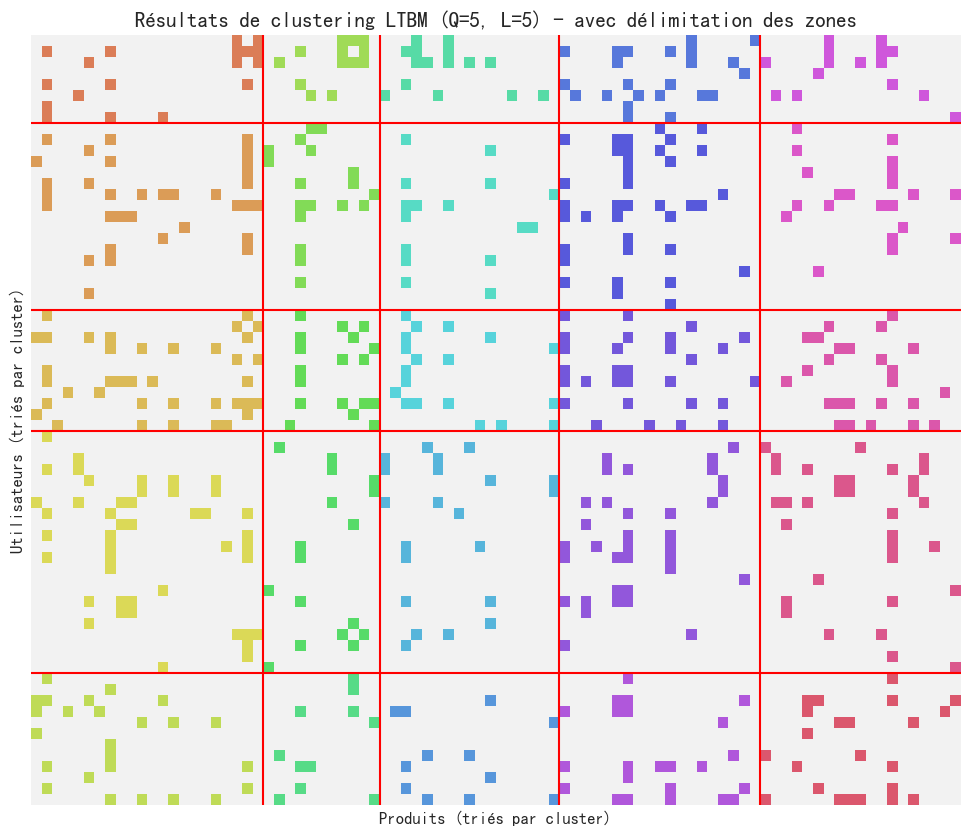


--- 提取各主题 Top 词汇 ---
Topic 1: fiber, touch, available, help, need, clean, wish, started
Topic 2: snacks, dozen, refreshing, almond, least, sugar, salon, cases
Topic 3: amazing, plastic, dogs, heat, ordinary, overly, advertised, salt
Topic 4: larabar, french, acidity, workout, aftertaste, bbq, eat, preference


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from LTBM_clean import LTBM  # Importe la classe LTBM que vous avez téléchargée

# --- 1. Pont de format de données ---
# W doit être converti de 'liste de listes' en 'dictionnaire', car la classe LTBM y accède via W[(i,j)]
def convert_W_to_dict(A, W_list):
    W_dict = {}
    # Récupérer les coordonnées (i, j) de toutes les interactions non nulles
    rows, cols = np.where(A != 0)
    for i, j in zip(rows, cols):
        # W_list[i][j] est la liste des documents (liste d'indices de mots) correspondant à cette interaction
        W_dict[(i, j)] = W_list[i][j]
    return W_dict

# Supposons que ltbm_data est la sortie de votre étape de préparation de données précédente
if 'ltbm_data' in locals():
    print("Conversion du format de données en cours...")
    A_dense = ltbm_data['A']
    W_list = ltbm_data['W']
    vocabulary = ltbm_data['vocabulary']

    # Conversion de W
    W_dict = convert_W_to_dict(A_dense, W_list)
    print(f"Conversion du dictionnaire W terminée, contenant {len(W_dict)} entrées d'interaction.")

    # --- 2. Configuration des hyperparamètres ---
    # Définir le nombre de clusters en fonction de la taille des données (100x100).
    # Il est conseillé de ne pas le définir trop grand, car des classes vides peuvent entraîner des erreurs de division par zéro.
    Q_users = 5      # Nombre de clusters utilisateurs (Clusters Ligne)
    L_products = 5   # Nombre de clusters produits (Clusters Colonne)
    K_topics = 4     # Nombre de sujets textuels (Topics)

    # Définir la distribution a priori de Dirichlet alpha (généralement un vecteur de uns)
    alpha = np.ones(K_topics)

    # --- 3. Initialisation du modèle ---
    print(f"\nInitialisation du modèle LTBM (Q={Q_users}, L={L_products}, K={K_topics})...")
    model = LTBM(
        A=A_dense,
        W=W_dict,
        dictionnary=vocabulary,
        alpha=alpha,
        Q=Q_users,
        L=L_products,
        K=K_topics,
        tol=1e-4,    # Seuil de convergence
        seed=42      # Graine aléatoire pour la reproductibilité
    )

    # --- 4. Entraînement du modèle ---
    print("Démarrage de l'entraînement (Algorithme C-VEM)...")
    # max_iter est le nombre d'itérations de la boucle externe (VEM+Greedy), max_iterVEM est le nombre d'itérations VEM interne
    try:
        model.fit(max_iter=15, max_iterVEM=50, verbose=1)
        print("Entraînement terminé !")
    except RuntimeWarning as w:
        print(f"Avertissement survenu pendant l'entraînement (souvent une division par zéro due à un cluster vide): {w}")
    except Exception as e:
        print(f"Erreur d'entraînement: {e}")

    # --- 5. Visualisation des résultats (avec lignes de division des zones) ---
    print("\nGénération du graphique des résultats de clustering avec divisions de zones...")

    # Récupérer les résultats de clustering
    # Y_clust: L'ID de cluster de chaque utilisateur (0 à Q-1)
    # X_clust: L'ID de cluster de chaque produit (0 à L-1)
    Y_clust = np.argmax(model.Y, axis=1)
    X_clust = np.argmax(model.X, axis=1)

    # Réorganiser la matrice originale pour regrouper les lignes/colonnes du même cluster
    # argsort retourne les indices triés
    row_order = np.argsort(Y_clust)
    col_order = np.argsort(X_clust)

    # Réorganiser la matrice A_clustered selon les indices triés
    # Note: model.A_clust() retourne déjà les valeurs de bloc calculées en fonction des ID de cluster,
    # mais l'ordre des lignes/colonnes est toujours l'ordre utilisateur/produit original, nous devons donc le réorganiser manuellement pour la visualisation
    A_clustered = model.A_clust()
    A_sorted = A_clustered[row_order][:, col_order]

    # --- Calcul de la position des lignes de division ---
    # Compter le nombre d'individus dans chaque cluster utilisateur
    user_cluster_counts = np.bincount(Y_clust, minlength=Q_users)
    # Calculer la somme cumulative comme position des lignes horizontales
    h_lines = np.cumsum(user_cluster_counts)[:-1] # Le dernier est le total, pas besoin de tracer une ligne

    # Compter le nombre d'éléments dans chaque cluster produit
    product_cluster_counts = np.bincount(X_clust, minlength=L_products)
    # Calculer la somme cumulative comme position des lignes verticales
    v_lines = np.cumsum(product_cluster_counts)[:-1]

    # --- Configuration des polices (pour CJK/Chinois) ---
    import platform
    system_name = platform.system()
    if system_name == "Windows":
        plt.rcParams['font.sans-serif'] = ['SimHei']
    elif system_name == "Darwin":
        plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    else:
        plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    # --- Tracé ---
    plt.figure(figsize=(12, 10))

    num_blocks = Q_users * L_products
    cmap = sns.color_palette("hls", num_blocks + 1)
    cmap[0] = (0.95, 0.95, 0.95) # Couleur de fond

    # Tracer la carte thermique
    sns.heatmap(A_sorted, cmap=cmap, cbar=False, xticklabels=False, yticklabels=False)

    # Tracer les lignes de division des zones (lignes rouges)
    # hlines: Lignes horizontales (position axe y, début axe x, fin axe x)
    plt.hlines(h_lines, *plt.xlim(), colors='red', linewidths=1.5)
    # vlines: Lignes verticales (position axe x, début axe y, fin axe y)
    plt.vlines(v_lines, *plt.ylim(), colors='red', linewidths=1.5)

    plt.title(f"Résultats de clustering LTBM (Q={Q_users}, L={L_products}) - avec délimitation des zones", fontsize=15)
    plt.xlabel("Produits (triés par cluster)", fontsize=12)
    plt.ylabel("Utilisateurs (triés par cluster)", fontsize=12)
    plt.show()

    # --- 6. Affichage des mots-sujets ---
    # model.beta est la matrice de distribution sujet-mot (K x V)
    print("\n--- Extraction des mots Top pour chaque sujet ---")
    top_n_words = 8
    for k in range(K_topics):
        # Récupérer les indices des mots ayant la plus haute probabilité dans le k-ième sujet
        top_indices = model.beta[k].argsort()[:-top_n_words - 1:-1]
        top_words = [vocabulary[i] for i in top_indices]
        print(f"Sujet {k+1}: {', '.join(top_words)}")

else:
    print("Veuillez d'abord exécuter le script de préparation des données pour générer 'ltbm_data'.")

开始读取并解析文件: foods.txt...
文件解析完成。共录入 568454 条评论。
初始数据量: 568454

正在筛选 Top 100 用户和 Top 100 美食...
筛选后数据量: 704 条评论
最终矩阵维度: 70 (Users) x 88 (Products)


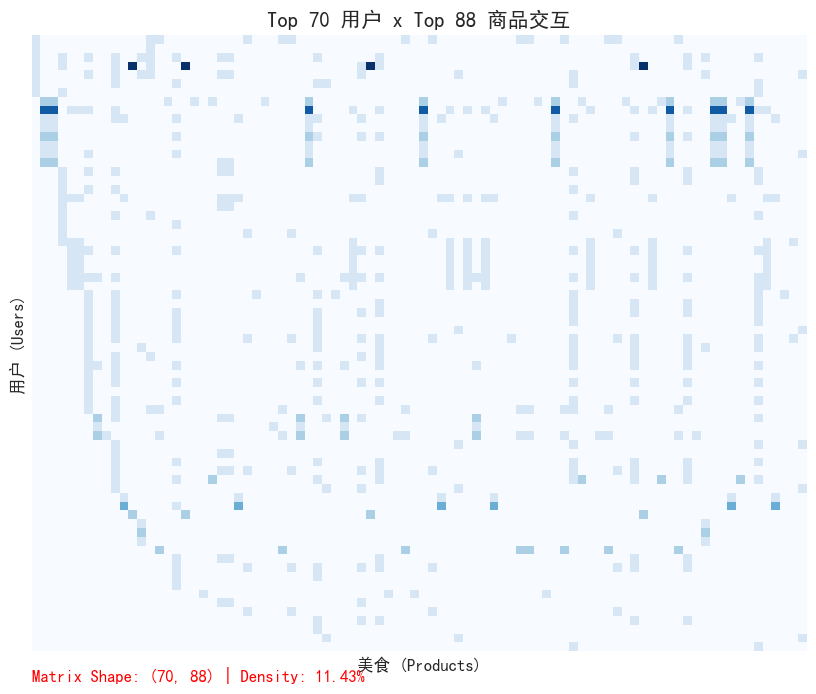


构建词汇表...
最终词汇表大小 V: 678 (包含大量噪音词汇)
构建文本矩阵 W...
数据准备完毕。包含 704 条有效文本评论。

数据准备完成。现在可以运行 LTBM 训练脚本了。


In [22]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
# import re # Supprimé : Les expressions régulières ne sont plus nécessaires

# --- Configuration des paramètres clés ---
FILE_PATH = 'foods.txt'  # Veuillez vous assurer que ce fichier est dans le même répertoire
TARGET_M_USERS = 100     # Nombre cible d'utilisateurs (M)
TARGET_P_PRODUCTS = 100  # Nombre cible de produits (P)
MIN_VOCAB_FREQUENCY = 20 # Fréquence minimale d'apparition d'un mot (pour construire le vocabulaire)
# Attention: STOP_WORDS a été supprimé

# --- 1. Analyse des données (Lecture à partir du fichier réel uniquement) ---
def parse_review_data(file_path: str) -> List[Dict]:
    """
    Analyse le fichier de données de commentaires Amazon en blocs.
    S'exécute uniquement si le fichier existe, sinon lève une exception.
    
    @param file_path: Chemin du fichier de données
    @return: Liste des dictionnaires de commentaires
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Erreur: Fichier introuvable '{file_path}'. Veuillez vous assurer que le chemin est correct.")

    print(f"Début de la lecture et de l'analyse du fichier: {file_path}...")
    data = []
    
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        current_review = {}
        for line in f:
            line = line.strip()
            if line:
                # Analyse de la structure clé: valeur
                if ':' in line:
                    try:
                        parts = line.split(':', 1)
                        key = parts[0].strip()
                        value = parts[1].strip()
                        
                        # Traiter les préfixes comme review/userId, ne garder que userId
                        if '/' in key:
                            key = key.split('/')[-1]
                        
                        current_review[key] = value
                    except ValueError:
                        continue
            else:
                # Ligne vide sépare les commentaires, sauvegarde l'enregistrement complet précédent
                if current_review:
                    # S'assurer que les champs nécessaires existent
                    if 'productId' in current_review and 'userId' in current_review and 'text' in current_review:
                        data.append(current_review)
                current_review = {}
        
        # Traiter le dernier commentaire possible à la fin du fichier
        if current_review and 'productId' in current_review and 'userId' in current_review and 'text' in current_review:
            data.append(current_review)
            
    print(f"Analyse du fichier terminée. {len(data)} commentaires enregistrés.")
    return data

# --- 2. Filtrage itératif (Prétraitement) ---
def filter_by_min_activity(df_in: pd.DataFrame, min_user: int, min_product: int) -> pd.DataFrame:
    """Supprime itérativement les données à très faible fréquence pour assurer la qualité des données."""
    df = df_in.copy()
    print(f"Taille initiale des données: {len(df)}")
    while True:
        # 1. Filtrer les produits
        product_counts = df['productId'].value_counts()
        popular_products = product_counts[product_counts >= min_product].index
        df_new = df[df['productId'].isin(popular_products)]
        
        # 2. Filtrer les utilisateurs
        user_counts = df_new['userId'].value_counts()
        active_users = user_counts[user_counts >= min_user].index
        df_new = df_new[df_new['userId'].isin(active_users)].copy()
        
        # 3. Vérifier la convergence
        if len(df_new) == len(df):
            break
        df = df_new
    return df

# --- 3. Nettoyage de texte (Conservation du filtrage de base uniquement) ---
def simple_clean(text: str) -> List[str]:
    """
    Nettoyage de texte : minuscules, tokenisation, suppression des mots de moins de 3 caractères
    (ne supprime pas les mots vides ni la ponctuation).
    
    @param text: Texte à nettoyer
    @return: Liste de mots nettoyés
    """
    
    # 1. Minuscules et tokenisation (Conserver la ponctuation et les symboles, ils seront traités comme des mots indépendants)
    words = str(text).lower().split()
    
    # 2. Supprimer les mots de moins de 3 caractères
    words = [w for w in words if len(w) >= 3]
    
    # Le filtrage des mots vides et le nettoyage par expression régulière ont été supprimés
    
    return words

# --- 4. Fonction de visualisation ---
def plot_interaction_heatmap(A_dense: np.ndarray, title="Carte thermique d'interaction Utilisateur-Produit"):
    """
    Trace la carte thermique de la matrice d'association binaire.
    
    @param A_dense: Matrice d'association binaire
    @param title: Titre du graphique
    """
    plt.figure(figsize=(10, 8))
    
    # Tracer la carte thermique (une couleur foncée indique une interaction)
    sns.heatmap(A_dense, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
    
    plt.title(title, fontsize=15)
    plt.xlabel("Produits (Products)", fontsize=12)
    plt.ylabel("Utilisateurs (Users)", fontsize=12)
    
    # Afficher la densité de la matrice
    density = np.sum(A_dense) / A_dense.size * 100
    plt.text(0, A_dense.shape[0] + 0.05 * A_dense.shape[0], 
             f"Forme de la matrice: {A_dense.shape} | Densité: {density:.2f}%", 
             fontsize=12, color='red')
    
    plt.show()

# --- Logique du programme principal ---
def prepare_ltbm_data_real(file_path: str, target_m: int, target_p: int, min_vocab_freq: int) -> Dict[str, Any]:
    """
    Prépare les matrices A (association) et W (texte) nécessaires pour le modèle LTBM.
    
    @param file_path: Chemin du fichier de données
    @param target_m: Nombre cible d'utilisateurs M
    @param target_p: Nombre cible de produits P
    @param min_vocab_freq: Fréquence minimale du vocabulaire
    @return: Dictionnaire contenant A, W, vocabulary, M, P, V
    """
    # 1. Chargement des données
    try:
        data = parse_review_data(file_path)
    except FileNotFoundError as e:
        print(e)
        return {}

    df = pd.DataFrame(data)
    if df.empty:
        print("Avertissement: L'ensemble de données est vide.")
        return {}

    # Conversion des types
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df.dropna(subset=['text', 'score'], inplace=True)

    # 2. Nettoyage préliminaire (au moins 1 commentaire pour être conservé)
    df = filter_by_min_activity(df, min_user=1, min_product=1)

    # 3. Étape clé : Filtrage Top-N (méthode de l'intersection)
    print(f"\nFiltrage des Top {target_m} utilisateurs et Top {target_p} produits...")
    
    # Trouver les M utilisateurs avec le plus de commentaires au total
    top_users = df['userId'].value_counts().head(target_m).index
    # Trouver les P produits avec le plus de commentaires au total
    top_products = df['productId'].value_counts().head(target_p).index
    
    # Ne conserver que les commentaires de ces utilisateurs Top sur ces produits Top (intersection)
    df_filtered = df[
        df['userId'].isin(top_users) & 
        df['productId'].isin(top_products)
    ].copy()

    # 4. Encodage des ID
    user_to_id = {u: i for i, u in enumerate(df_filtered['userId'].unique())}
    prod_to_id = {p: i for i, p in enumerate(df_filtered['productId'].unique())}
    
    df_filtered['uid_idx'] = df_filtered['userId'].map(user_to_id)
    df_filtered['pid_idx'] = df_filtered['productId'].map(prod_to_id)
    
    M = len(user_to_id)
    P = len(prod_to_id)
    
    print(f"Taille des données après filtrage: {len(df_filtered)} commentaires")
    print(f"Dimensions finales de la matrice: {M} (Utilisateurs) x {P} (Produits)")

    # 5. Construction de la matrice A (Matrice d'association/d'incidence)
    rows = df_filtered['uid_idx']
    cols = df_filtered['pid_idx']
    data_ones = np.ones(len(df_filtered))
    
    A_dense = csr_matrix((data_ones, (rows, cols)), shape=(M, P)).toarray()
    
    # Tracer la carte thermique pour confirmer la densité
    plot_interaction_heatmap(A_dense, title=f"Interaction Top {M} Utilisateurs x Top {P} Produits")

    # 6. Construction du vocabulaire (Vocabulary)
    print("\nConstruction du vocabulaire...")
    all_words = []
    
    # Appeler simple_clean
    df_filtered['cleaned_text'] = df_filtered['text'].apply(simple_clean)
    
    for words in df_filtered['cleaned_text']:
        all_words.extend(words)
        
    word_counts = pd.Series(all_words).value_counts()
    vocabulary = list(word_counts[word_counts >= min_vocab_freq].index)
    word_to_idx = {w: i for i, w in enumerate(vocabulary)}
    V = len(vocabulary)
    print(f"Taille finale du vocabulaire V: {V} (Contient beaucoup de bruit)")

    # 7. Construction de la matrice W (Liste de listes M x P stockant les documents)
    print("Construction de la matrice de texte W...")
    W_matrix = [[[] for _ in range(P)] for _ in range(M)]
    
    valid_reviews_count = 0
    for _, row in df_filtered.iterrows():
        u = row['uid_idx']
        p = row['pid_idx']
        words = row['cleaned_text']
        
        # Convertir le texte en liste d'indices de mots
        doc_indices = [word_to_idx[w] for w in words if w in word_to_idx]
        
        # Seuls les documents non vides sont ajoutés au modèle
        if doc_indices:
            W_matrix[u][p].append(doc_indices)
            valid_reviews_count += 1
            
    print(f"Préparation des données terminée. Contient {valid_reviews_count} commentaires textuels valides.")

    return {
        'A': A_dense,
        'W': W_matrix,
        'vocabulary': vocabulary,
        'M': M,
        'P': P,
        'V': V
    }

# --- Exécution du programme principal ---
if __name__ == "__main__":
    ltbm_data = prepare_ltbm_data_real(FILE_PATH, TARGET_M_USERS, TARGET_P_PRODUCTS, MIN_VOCAB_FREQUENCY)
    
    # Si la préparation des données est réussie, ltbm_data contiendra toutes les entrées nécessaires pour le modèle
    if ltbm_data:
        # Définir les données comme variables globales pour le deuxième script
        globals()['ltbm_data'] = ltbm_data
        print("\nPréparation des données terminée. Vous pouvez maintenant exécuter le script d'entraînement LTBM.")

正在转换数据格式...
W 字典转换完成，包含 583 个交互条目。

初始化 LTBM 模型 (Q=5, L=5, K=4)...
开始训练 (C-VEM 算法)...
训练出错: np.int64(0)

生成带区域划分的聚类结果图...


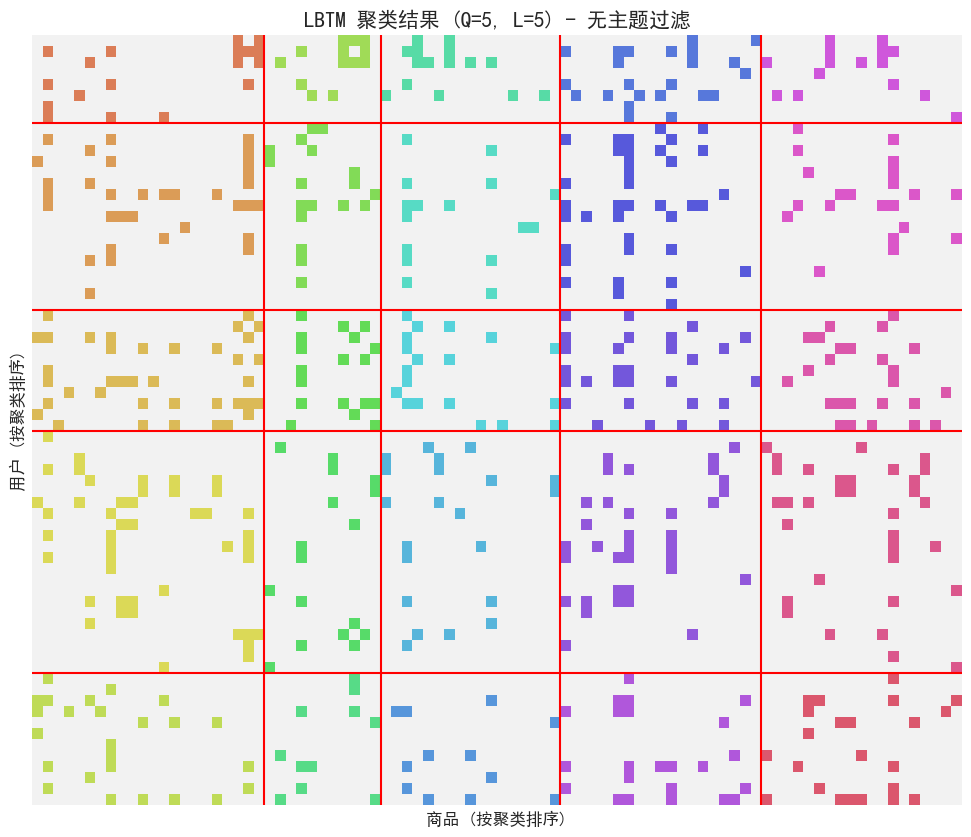


--- 提取各主题 Top 词汇 ---
Topic 1: sour, plus, so,, baby, drinking, compared, 2)</a>,, she's
Topic 2: />she, drive, sour, first, aroma, that's, there's, tea,
Topic 3: crunchy,, need, junk, highly, sugar, comes, might, list.
Topic 4: purchase, roast, strange, that's, chilled, calories, claims, order


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 确保您的 LTBM 类文件 (例如 LTBM.py) 在同一目录下，并且可以被正确导入
try:
    from LTBM_clean import LTBM  # 假设 LTBM 类在 LTBM_clean.py 中
except ImportError:
    print("错误: 找不到 LTBM 类。请确保 LTBM 类文件在当前目录下且可导入。")

# --- 1. 数据格式桥接 ---
# 必须将 W 从“列表的列表”转换为“字典”，因为 LTBM 类使用 W[(i,j)] 访问
def convert_W_to_dict(A, W_list):
    W_dict = {}
    # 获取所有非零交互的坐标 (i, j)
    rows, cols = np.where(A != 0)
    for i, j in zip(rows, cols):
        # W_list[i][j] 是该交互对应的文档列表（词索引列表）
        # 检查是否真的存在文档，以避免不必要的键值
        if W_list[i][j]:
            W_dict[(i, j)] = W_list[i][j]
    return W_dict

# 假设 ltbm_data 是您上一步数据准备的输出
if 'ltbm_data' in locals():
    print("正在转换数据格式...")
    A_dense = ltbm_data['A']
    W_list = ltbm_data['W']
    vocabulary = ltbm_data['vocabulary']
    
    # 转换 W
    W_dict = convert_W_to_dict(A_dense, W_list)
    print(f"W 字典转换完成，包含 {len(W_dict)} 个交互条目。")

    # --- 2. 设置超参数 ---
    # 根据数据规模(100x100)设置聚类数。
    Q_users = 5      # 用户聚类数 (Row Clusters)
    L_products = 5   # 产品聚类数 (Column Clusters)
    K_topics = 4     # 文本主题数 (Topics)
    
    # 设置 Dirichlet 先验 alpha (通常设为全1向量)
    alpha = np.ones(K_topics)

    # --- 3. 初始化模型 ---
    print(f"\n初始化 LTBM 模型 (Q={Q_users}, L={L_products}, K={K_topics})...")
    
    # 检查 LTBM 类是否已加载
    if 'LTBM' not in locals():
        print("无法初始化 LTBM 模型，请确保 LTBM 类已正确导入。")
    else:
        model = LTBM(
            A=A_dense, 
            W=W_dict, 
            dictionnary=vocabulary, 
            alpha=alpha, 
            Q=Q_users, 
            L=L_products, 
            K=K_topics, 
            tol=1e-4,    # 收敛阈值
            seed=42      # 随机种子，保证结果可复现
        )

        # --- 4. 模型训练 ---
        print("开始训练 (C-VEM 算法)...")
        # max_iter 是外层循环次数(VEM+Greedy)，max_iterVEM 是内层 VEM 迭代次数
        try:
            model.fit(max_iter=15, max_iterVEM=50, verbose=1)
            print("训练完成！")
        except RuntimeWarning as w:
            print(f"训练中出现警告 (通常是空聚类导致的除零): {w}")
        except Exception as e:
            print(f"训练出错: {e}")

        # --- 5. 结果可视化 (带区域划分线) ---
        print("\n生成带区域划分的聚类结果图...")
        
        # 获取聚类结果
        # Y_clust: 每个用户所属的聚类 ID (0 到 Q-1)
        # X_clust: 每个产品所属的聚类 ID (0 到 L-1)
        Y_clust = np.argmax(model.Y, axis=1)
        X_clust = np.argmax(model.X, axis=1)
        
        # 对原始矩阵进行重排，将同一聚类的行/列聚集在一起
        row_order = np.argsort(Y_clust)
        col_order = np.argsort(X_clust)
        
        # model.A_clust() 返回基于聚类 ID 计算出的块值
        A_clustered = model.A_clust()
        A_sorted = A_clustered[row_order][:, col_order]

        # --- 计算分界线位置 ---
        # 统计每个用户聚类有多少人
        user_cluster_counts = np.bincount(Y_clust, minlength=Q_users)
        # 计算累积和，作为水平线的位置
        h_lines = np.cumsum(user_cluster_counts)[:-1] # 最后一个是总数，不需要画线
        
        # 统计每个产品聚类有多少个
        product_cluster_counts = np.bincount(X_clust, minlength=L_products)
        # 计算累积和，作为垂直线的位置
        v_lines = np.cumsum(product_cluster_counts)[:-1]

        # --- 字体设置 ---
        import platform
        system_name = platform.system()
        # 仅为绘图设置字体，确保中文显示
        if system_name == "Windows":
            plt.rcParams['font.sans-serif'] = ['SimHei']
        elif system_name == "Darwin":
            plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
        else:
            plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False 

        # --- 绘图 ---
        plt.figure(figsize=(12, 10))
        
        # 创建颜色映射，用于可视化聚类块
        num_blocks = Q_users * L_products
        cmap = sns.color_palette("hls", num_blocks + 1)
        cmap[0] = (0.95, 0.95, 0.95) # 背景色
        
        # 绘制热力图
        sns.heatmap(A_sorted, cmap=cmap, cbar=False, xticklabels=False, yticklabels=False)
        
        # 绘制区域划分线
        plt.hlines(h_lines, *plt.xlim(), colors='red', linewidths=1.5)
        plt.vlines(v_lines, *plt.ylim(), colors='red', linewidths=1.5)
        
        plt.title(f"LBTM 聚类结果 (Q={Q_users}, L={L_products}) - 无主题过滤", fontsize=15)
        plt.xlabel("商品 (按聚类排序)", fontsize=12)
        plt.ylabel("用户 (按聚类排序)", fontsize=12)
        plt.show()

        # --- 6. 查看主题词 ---
        # model.beta 是主题-词分布矩阵 (K x V)
        print("\n--- 提取各主题 Top 词汇 ---")
        top_n_words = 8
        for k in range(K_topics):
            # 获取第 k 个主题中概率最高的词的索引
            top_indices = model.beta[k].argsort()[:-top_n_words - 1:-1]
            top_words = [vocabulary[i] for i in top_indices]
            print(f"Topic {k+1}: {', '.join(top_words)}")

else:
    print("请先运行数据准备脚本生成 'ltbm_data'。")

Début de l'entraînement MBL (Q=5, L=5)...
Converge à l'itération 30


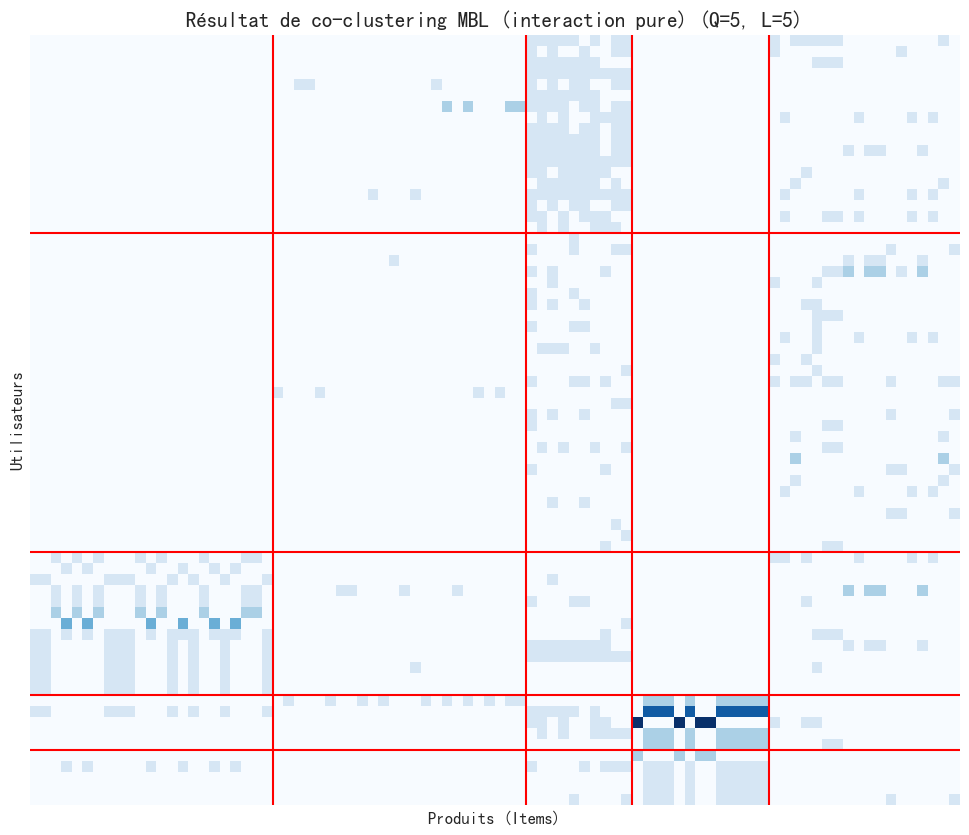

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import digamma

class SimpleLBM:
    def __init__(self, A, Q, L, tol=1e-6, max_iter=100, seed=None):
        """
        Modèle de Blocs Latents Binaire Simple (LBM de Bernoulli)
        A: Matrice d'interaction M x P (0/1)
        Q: Nombre de clusters utilisateurs
        L: Nombre de clusters produits
        """
        self.A = A
        self.M, self.P = A.shape
        self.Q = Q
        self.L = L
        self.tol = tol
        self.max_iter = max_iter
        
        if seed:
            np.random.seed(seed)
            
        # Initialisation des paramètres
        # tau: Paramètre variationnel Q(Y) -> Probabilité que l'utilisateur appartienne à chaque classe (M x Q)
        self.tau = np.random.dirichlet(np.ones(Q), size=self.M)
        # phi: Paramètre variationnel Q(X) -> Probabilité que le produit appartienne à chaque classe (P x L)
        self.phi = np.random.dirichlet(np.ones(L), size=self.P)
        
        # Paramètres du modèle
        self.pi = np.random.rand(Q, L) # pi_ql: Probabilité d'interaction dans le bloc q, l
        self.rho = np.ones(Q) / Q      # Priori de classe utilisateur
        self.delta = np.ones(L) / L    # Priori de classe produit

    def fit(self):
        print(f"Début de l'entraînement MBL (Q={self.Q}, L={self.L})...")
        prev_vlb = -np.inf
        
        for n_iter in range(self.max_iter):
            # --- Étape M: Mise à jour des paramètres du modèle ---
            # Calcul de l'interaction attendue dans le bloc
            # Le dénominateur est la somme des probabilités d'appartenance au bloc
            
            # Dénominateur: sum_i sum_j tau_iq * phi_jl
            sum_tau = np.sum(self.tau, axis=0) # shape (Q,)
            sum_phi = np.sum(self.phi, axis=0) # shape (L,)
            denom = np.outer(sum_tau, sum_phi) # Q x L
            
            # Numérateur: sum_i sum_j tau_iq * phi_jl * A_ij
            # = tau.T @ A @ phi
            num = self.tau.T @ self.A @ self.phi # Q x L
            
            # Mise à jour de pi (éviter la division par zéro)
            self.pi = num / np.maximum(denom, 1e-10)
            
            # Mise à jour de rho, delta (Priori de classe)
            self.rho = sum_tau / self.M
            self.delta = sum_phi / self.P
            
            # --- Étape E: Mise à jour des paramètres variationnels tau, phi ---
            # Mise à jour de tau (fixer phi)
            log_pi = np.log(np.maximum(self.pi, 1e-10))
            log_1_pi = np.log(np.maximum(1 - self.pi, 1e-10))
            
            # Terme 1 (A=1): A @ phi @ log_pi.T -> M x Q
            term1 = self.A @ self.phi @ log_pi.T
            
            # Terme 2 (A=0): (1-A) @ phi @ log_1_pi.T -> M x Q
            # Utilisation de l'identité pour (1-A) pour l'efficacité
            C = self.phi @ log_1_pi.T # P x Q
            sum_C = np.sum(C, axis=0) # 1 x Q
            term2 = sum_C - (self.A @ C)
            
            # Calcul du log_tau
            log_tau = np.log(np.maximum(self.rho, 1e-10)) + term1 + term2
            # Normalisation Softmax
            log_tau -= np.max(log_tau, axis=1, keepdims=True)
            self.tau = np.exp(log_tau)
            self.tau /= np.sum(self.tau, axis=1, keepdims=True)
            
            # Mise à jour de phi (fixer tau) - Opération symétrique
            # Terme 1: A.T @ tau @ log_pi -> P x L
            term1_phi = self.A.T @ self.tau @ log_pi
            
            # Terme 2: (1-A).T @ tau @ log_1_pi
            D = self.tau @ log_1_pi # M x L
            sum_D = np.sum(D, axis=0) # 1 x L
            term2_phi = sum_D - (self.A.T @ D)
            
            # Calcul du log_phi
            log_phi = np.log(np.maximum(self.delta, 1e-10)) + term1_phi + term2_phi
            log_phi -= np.max(log_phi, axis=1, keepdims=True)
            self.phi = np.exp(log_phi)
            self.phi /= np.sum(self.phi, axis=1, keepdims=True)
            
            # --- Vérification simplifiée de la convergence (basée sur la variation des paramètres) ---
            if n_iter > 0:
                diff = np.linalg.norm(self.pi - prev_pi)
                if diff < self.tol:
                    print(f"Converge à l'itération {n_iter}")
                    break
            prev_pi = self.pi.copy()
            
    def get_co_clustering(self):
        # Assignation par clustering dur
        row_labels = np.argmax(self.tau, axis=1)
        col_labels = np.argmax(self.phi, axis=1)
        
        # Réarrangement de la matrice
        row_indices = np.argsort(row_labels)
        col_indices = np.argsort(col_labels)
        
        A_sorted = self.A[row_indices][:, col_indices]
        
        return A_sorted, row_labels, col_labels

# --- Programme principal : Exécution du MBL ---
# Suppose que 'ltbm_data['A']' existe (issu du script de préparation des données précédent)
if 'ltbm_data' in locals():
    # Nécessaire pour éviter une erreur si ltbm_data n'est pas défini (par exemple, si le script est exécuté seul)
    try:
        A_dense = ltbm_data['A']
    except NameError:
        print("Erreur: 'ltbm_data' non trouvé. Veuillez d'abord exécuter le script de préparation des données.")
        A_dense = None # Assurer que la suite du code ne s'exécute pas

    if A_dense is not None:
        # Définir le nombre de clusters (pour la comparaison)
        Q_lbm = 5
        L_lbm = 5
        
        lbm = SimpleLBM(A_dense, Q=Q_lbm, L=L_lbm, seed=42)
        lbm.fit()
        
        # Obtenir les résultats
        A_sorted_lbm, row_labels, col_labels = lbm.get_co_clustering()
        
        # --- Tracé ---
        
        plt.figure(figsize=(12, 10))
        
        # Tracer la carte thermique
        sns.heatmap(A_sorted_lbm, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
        
        # Tracer les lignes de division des blocs
        sorted_rows = np.sort(row_labels)
        sorted_cols = np.sort(col_labels)
        
        # Déterminer les positions des lignes (où la valeur du label change)
        h_lines = np.where(sorted_rows[:-1] != sorted_rows[1:])[0] + 1
        v_lines = np.where(sorted_cols[:-1] != sorted_cols[1:])[0] + 1
        
        plt.hlines(h_lines, *plt.xlim(), colors='red', linewidths=1.5)
        plt.vlines(v_lines, *plt.ylim(), colors='red', linewidths=1.5)
        
        plt.title(f"Résultat de co-clustering MBL (interaction pure) (Q={Q_lbm}, L={L_lbm})", fontsize=15)
        plt.xlabel("Produits (Items)", fontsize=12)
        plt.ylabel("Utilisateurs", fontsize=12)
        plt.show()
    
else:
    print("Veuillez d'abord exécuter le script de préparation des données pour générer 'ltbm_data'.")